In [61]:
import pandas as pd 
import matplotlib.pyplot as plt
import numpy as np
from networkx.drawing.nx_agraph import to_agraph 
import networkx as nx
import pygraphviz as pgv
from IPython.display import display_svg,display

In [62]:
import pandas as pd

print(nx.__version__)

2.3


# データの想定

In [63]:
import random, string

def randomname(n):
    return ''.join(random.choices(string.ascii_letters + string.digits, k=n))


In [64]:
url =['NeUq.com', 'AFjE.com', 'Kzb0.com', 'q1Tk.com', 'sFRR.com']
url


['NeUq.com', 'AFjE.com', 'Kzb0.com', 'q1Tk.com', 'sFRR.com']

In [65]:
edges_weight = [
    (0, 1, 3), (1, 2, 1), (1, 3, 3),(2, 3, 4), (1, 0, 2),(2, 0, 7),(3, 1, 2),(1, 4, 2),
    ]

In [66]:
current_url = []
to_url = []
for t in edges_weight:
    for i in range(t[2]):
        current_url.append(url[t[0]])
        to_url.append(url[t[1]])


In [67]:
data = pd.DataFrame({"url":current_url, "to":to_url})

In [68]:
data.head()

,url,to
0,NeUq.com,AFjE.com
1,NeUq.com,AFjE.com
2,NeUq.com,AFjE.com
3,AFjE.com,Kzb0.com
4,AFjE.com,q1Tk.com


In [50]:
data_count = data.groupby(["url", "to"]).size().reset_index(name = "count")

In [51]:
data_sum = data_count.groupby(["url"]).sum().reset_index().rename(columns = {"count":"sum"})

In [52]:
data_merged = pd.merge(data_count,data_sum, how = "left", on = "url")

In [53]:
data_merged["weight"] = data_merged["count"]/data_merged["sum"]

In [54]:
data_merged.head()

,url,to,count,sum,weight
0,AFjE.com,Kzb0.com,1,8,0.125000
1,AFjE.com,NeUq.com,2,8,0.250000
2,AFjE.com,q1Tk.com,3,8,0.375000
3,AFjE.com,sFRR.com,2,8,0.250000
4,Kzb0.com,NeUq.com,7,11,0.636364


# 描画

In [55]:
G = nx.MultiDiGraph()
for i, data in data_merged.iterrows():
    G.add_edge(data["url"],data["to"], weight=data["weight"],label=data["count"])
    
A = to_agraph(G) 
A.layout('dot')                                                                 
A.draw('multi.png')   


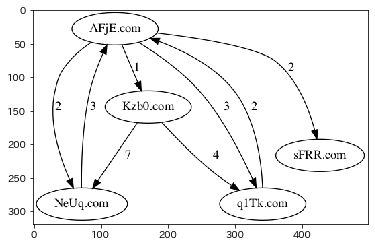

In [56]:
from PIL import Image

#画像の読み込み
im = Image.open("../fig/multi.png")

#画像をarrayに変換
im_list = np.asarray(im)
#貼り付け
plt.imshow(im_list)
#表示
plt.show()

In [57]:
pr = nx.pagerank_numpy(G, alpha=0.85)
pr

{'AFjE.com': 0.3833304457546468,
 'Kzb0.com': 0.0935575494432224,
 'NeUq.com': 0.18489253832166933,
 'q1Tk.com': 0.203933057175808,
 'sFRR.com': 0.1342864093046534}

In [58]:
class PageRank():
    
    def __init__(self,d = 0.85,eta = 0.000001, max_iter = 100):
        self.d = d
        self.eta = eta
        self.mat_iter = max_iter
    
    def get_rank(self,data):
        url_ls = list(set(list(data_merged["url"].values) + list(data_merged["to"].values)))

        url_dic ={_url:i for i,_url in enumerate(url_ls)}            
    
        edges_weight = [(url_dic[data["url"]], url_dic[data["to"]], data["weight"]) for i,data in data_merged.iterrows()]

        self.N = len(url_dic.keys())
        
        mat = np.zeros((self.N, self.N))
        for t in edges_weight:
            mat[t[0],t[1]] = t[2]
            
        sm = np.sum(mat, axis = 1)

        # sthostic
        for i, v in enumerate(sm):
            mat[i] =1/self.N if v == 0 else mat[i]/v

        
        # primitive
        
        # primitive adjustmentのための行列(G行列を作成)
        pr = np.full_like(np.zeros((self.N,self.N)), 1/self.N)
        G = self.d * mat + (1-self.d)  * pr
        r = self._cal(G)
        rv_url_dic = {v:k for k, v in url_dic.items()}
        
        return {rv_url_dic[i]:_rk for i, _rk in enumerate(r)}
            
        
        
        
    def _cal(self,G):
        # 固有値ベクトルの初期値

        r = np.array([1/self.N for i in range(self.N)])
        for _ in range(self.mat_iter):
            new_r = np.dot(r.T,G)
            diff = np.sum(np.abs(new_r - r))
            if diff < self.eta:
                break
            r = new_r
        return r


In [59]:
model = PageRank()

In [60]:
model.get_rank(data_merged)

{'AFjE.com': 0.38333069574213952,
 'Kzb0.com': 0.093557524234423123,
 'NeUq.com': 0.1848924903831852,
 'q1Tk.com': 0.20393295225260635,
 'sFRR.com': 0.13428633738764656}